In [43]:
import pandas as pd
from datetime import datetime
from ltv_calculation_functions import *

# Loading and preparing the data

In [44]:
file_name = 'SubscriptionsData.csv'
df = load_data(file_name)

df = timestamp_translator(df)
df.total_renewals = df.total_renewals.fillna(0)

# Getting to know the data

In [45]:
sampling_report(df)

Total Data: 11997 lines
Number of lines about the annual subscription: 11340 lines (94.52%)
Number of lines about the weekly subscription: 657 lines (5.48%)

Completed user - a user who has already purchased a subscription a certain number of times and eventually canceled it 
(the user's lifetime is presumably already over)

Number of Completed users: 1612 (13.44%)
Number of active users: 3842 (32.02%)
Number of users who still have a free trial period: 23 (0.19%)
Number of users who failed to issue a receipt: 6509 (54.26%)
Number of users who did not renew their subscription after the trial period: 11 (0.09%)


##### We have 657 lines for weekly subscriptions versus 11340 lines for annual subscriptions. Calculation based on data for weekly subscriptions will have a larger error than the calculation based on data on annual subscriptions.

# 1. Calculation of LTV for annual and weekly subscriptions.

Average purchase size (AOV - Average Order Value) - average cost or average check

Number of purchases (RPR - Repeat Purchase Rates) - frequency of purchases for the period

Retention period (Lifetime) - customer lifetime

LTV = Average purchase size x Number of purchases x Retention period

### AOV

average_cost = total_spent / total_purchases

total_purchases = total_renewals + 1

Average Order Value - is the average of the average_cost.

All rows in which total_spent and total_renewals are equal to 0 were removed from the data table, since such a case can only occur in three cases: free_trial, cancelled_trial, expired right after the trial period

In [46]:
df = aov_calculation(df)

#### Below you can see the statistics of the Average cost (per year and week respectively)

In [47]:
df.loc[df.all_purchased_product_ids == 'com.app.year'].average_cost.describe()

count    11340.000000
mean        35.567168
std         36.470018
min          0.000000
25%          0.000000
50%          0.000000
75%         69.990000
max        139.980000
Name: average_cost, dtype: float64

In [48]:
df.loc[df.all_purchased_product_ids == 'com.app.week'].average_cost.describe()

count    657.000000
mean       6.579966
std       10.209633
min        0.000000
25%        0.000000
50%        6.990000
75%        6.990000
max       77.216037
Name: average_cost, dtype: float64

### RPR

We calculate LTV for weekly and yearly subscriptions, so we can equate RPR to 1 (1 subscription fee per week or 1 subscription fee per year). 

In [49]:
df['rpr'] = 1

### Lifetime

Completed user data makes up 13% of the total data.

The total amount of data is approximately equal to 12k, so the calculation of the lifetime based on these data alone is a fairly representative method. That is exactly what we will do!

We have data on annual and weekly subscriptions. Therefore, the number of purchases of Completed users is equal to the lifetime in years or weeks, respectively.

Lifetime = number_of_purchases = total_renewals + 1

In [50]:
df_y = df.loc[df.all_purchased_product_ids == 'com.app.year']
df_w = df.loc[df.all_purchased_product_ids == 'com.app.week']

lifetime_y = print_lifetime_stat(df_y)
lifetime_w = print_lifetime_stat(df_w)

The average user lifetime for a ['com.app.year'] is 1.0675589547482474 year
The average user lifetime for a ['com.app.week'] is 4.069767441860465 week


##### As we can see, the lifetime for a weekly subscription looks unrealistic. If we plot renewals for all the weekly subscription data, we will see that it is relatively uniform and similar to the standard view of the lifetime plot. 

In [51]:
df_w_describe = df_w.groupby('total_renewals').describe()
total_renewals_week = df_w_describe.total_spent['count'].index.tolist()
number_of_users_week = df_w_describe.total_spent['count'].tolist()

name = 'Total renewals vs. Users Graph for All Weekly Subscription Data'
xaxis_name = 'total renewals'
yaxis_name = 'number of users'
plotting(total_renewals_week, number_of_users_week, name, xaxis_name, yaxis_name)

##### But if we build the same graph, but only for data on weekly subscriptions with the status cancelled we will see that this chart has a sharp drop. This is most likely due to the fact that there is too little data on weekly subscriptions in this sample.

In [52]:
df_w_cancelled = df_w.loc[df_w.status == 'cancelled']
df_w_cancelled_describe = df_w_cancelled.groupby('total_renewals').describe()
total_renewals_week_cancelled = df_w_cancelled_describe.total_spent['count'].index.tolist()
number_of_users_week_cancelled = df_w_cancelled_describe.total_spent['count'].tolist()

name = 'Total renewals vs. Users Graph for All Weekly Subscription Data with cancelled status'
xaxis_name = 'total renewals'
yaxis_name = 'number of users'
plotting(total_renewals_week_cancelled, number_of_users_week_cancelled, name, xaxis_name, yaxis_name)

##### However, we cannot use the lifetime of an annual subscription to increase the LTV of a weekly subscription - because in reality they have big differences. Therefore, in the further calculation, the lifetime remains as it is.

### Calculation LTV

In [53]:
df = ltv_calculation(df, lifetime_y, lifetime_w)

df_y = df.loc[df.all_purchased_product_ids == 'com.app.year']
df_w = df.loc[df.all_purchased_product_ids == 'com.app.week']

df_describe_y, ltv_y, number_of_users_y = describe_ltv(df_y)
df_describe_w, ltv_w, number_of_users_w = describe_ltv(df_w)

name_y = 'LTV vs. Users Chart for an Annual Subscription'
name_w = 'LTV vs. Users Chart for an Weekly Subscription'

xaxis_name = 'LTV'
yaxis_name = 'number of users'

In [54]:
plotting(ltv_y, number_of_users_y, name_y, xaxis_name, yaxis_name)

##### On the graph, we can see that more than 5k users of the annual subscription have LTV = 0. All of these entries have total_spent = 0.
##### These are either free_trial and cancelled_trial status users, there are also expired status users but they received trial status immediately after the trial period (there was no payment as in the cancelled_trial)

#### We see that, excluding zeros, for most users, the LTV annual subscription is approximately 75

In [55]:
plotting(ltv_w, number_of_users_w, name_w, xaxis_name, yaxis_name)

##### As mentioned earlier, there is much less data on weekly subscriptions than on annual ones. More than a third of them turned out to be zero (the explanation is the same as in the case of the annual subscription).
##### We can conditionally conclude that the LTV of a user of a weekly subscription is approximately equal to 25, however, I believe that this metric is calculated on a non-representative data sample

## Self-checking on Completed user data

#### com.app.year data

In [56]:
df.loc[(df.status == 'cancelled') & (df.all_purchased_product_ids == 'com.app.year')].total_spent.describe()

count    1569.000000
mean       77.695250
std        20.232219
min        52.134662
25%        69.990000
50%        69.990000
75%        69.990000
max       182.782425
Name: total_spent, dtype: float64

##### As we can see on average the total amount spent by the Completed user of the annual subscription is 77. According to our calculation, the LTV on average for the user of the annual subscription is 75, which indicates that the accuracy of the calculations is not bad.

#### com.app.week data

In [57]:
df.loc[(df.status == 'cancelled') & (df.all_purchased_product_ids == 'com.app.week')].total_spent.describe()

count     43.000000
mean      88.798381
std       54.739680
min        8.801876
25%       76.980000
50%       76.980000
75%       97.950000
max      405.420000
Name: total_spent, dtype: float64

##### Here we have a big difference between the LTV and the data on how much the Completed user spends. However, this is expected in a non-representative sample.

# 2. Distribution of LTV across different countries

In [58]:
country_by_top = distribution_report(df, 'ip_country')

Number of ip_country: 122

Top 10 ip_country by number of users: 
1. US - 9461 users (and 1236 of them are completed users)
2. GB - 1077 users (and 127 of them are completed users)
3. AU - 254 users (and 54 of them are completed users)
4. CA - 247 users (and 61 of them are completed users)
5. NZ - 60 users (and 18 of them are completed users)
6. AE - 48 users (and 3 of them are completed users)
7. PH - 43 users (and 4 of them are completed users)
8. VN - 43 users (and 2 of them are completed users)
9. PR - 38 users (and 5 of them are completed users)
10. NG - 37 users (and 1 of them are completed users)

For other ip_country the number of users is from 1 to 31 people


##### For the calculation I take the first 4 countries, since we have very little data for the rest of the countries.

In [59]:
country_by_top_4 = country_by_top[:4]
top_chart_vis(df, 'ip_country', country_by_top_4)

Numb of zero: 4838 (51.13624352605433%)
LTV statistics: mean 68.72370176985515, min 5.1723044397463, max 284.84302325581393


Numb of zero: 635 (58.96007428040854%)
LTV statistics: mean 89.47318555565577, min 27.7618878871702, max 215.62705531526007


Numb of zero: 76 (29.921259842519685%)
LTV statistics: mean 86.75865102458702, min 13.798096532297185, max 199.66370348054508


Numb of zero: 69 (27.93522267206478%)
LTV statistics: mean 72.55924194116167, min 11.787674144121873, max 162.94252815847096


##### From the graphs we can see that the best LTV is in GB. In other cases, LTV is approximately 70 to 80.
##### I did not display zero LTVs on the graph, since without them the graph is much clearer. I wrote the number of zero measurements below the graph. 

##### However, there is not much data. There is no point in stating LTV for other countries, since the amount of data on them is completely unrepresentative.

# Distribution of LTV by media sources

In [60]:
media_df = df.loc[df.media_source != 0]
media_source_by_top = distribution_report(media_df, 'media_source')

Number of media_source: 15

Top 10 media_source by number of users: 
1. Source D - 3086 users (and 627 of them are completed users)
2. Source F - 2118 users (and 320 of them are completed users)
3. Source A - 1776 users (and 278 of them are completed users)
4. Source X - 750 users (and 102 of them are completed users)
5. Source C - 586 users (and 83 of them are completed users)
6. Source E - 147 users (and 26 of them are completed users)
7. Source B - 117 users (and 1 of them are completed users)
8. Source G - 66 users (and 14 of them are completed users)
9. Source I - 63 users (and 7 of them are completed users)
10. Source K - 54 users (and 11 of them are completed users)

For other media_source the number of users is from 1 to 28 people


In [61]:
media_source_by_top_6 = media_source_by_top[:6]
top_chart_vis(df, 'media_source', media_source_by_top_6)

Numb of zero: 1044 (33.830200907323395%)
LTV statistics: mean 91.24440324316812, min 13.798096532297185, max 215.62705531526007


Numb of zero: 1188 (56.09065155807365%)
LTV statistics: mean 96.5045966496631, min 28.447674418604652, max 199.37790697674413


Numb of zero: 744 (41.891891891891895%)
LTV statistics: mean 83.9298502981941, min 15.59219198573723, max 156.6453488372093


Numb of zero: 280 (37.333333333333336%)
LTV statistics: mean 59.88051228185527, min 5.1723044397463, max 314.25131540271855


Numb of zero: 81 (13.822525597269625%)
LTV statistics: mean 82.61177585411515, min 18.00408808603884, max 199.37790697674413


Numb of zero: 37 (25.170068027210885%)
LTV statistics: mean 80.9920064315903, min 28.447674418604652, max 156.6453488372093


##### As you can see, the best average LTV for source F.
##### The rest of the resources are not on the charts, as there is too little data for them. Therefore, the worst of these 6 on average LTV is source X.

# Cohort analysis

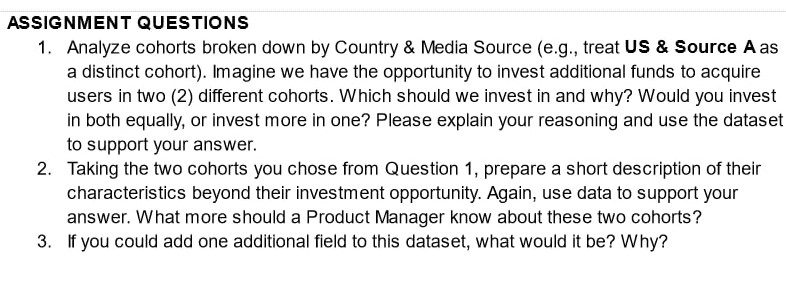

##### To answer the following questions, we take cohorts resource A and country US. 

##### Before answering question 1, I need to consider question 2.

##### Let's take a look below at the data on these cohorts, prepared at the stage of calculating LTV.

In [62]:
media_df_A = media_df.loc[media_df.media_source == 'Source A']
distribution_report(media_df_A, 'media_source')
top_chart_vis(df, 'media_source', ['Source A'])

Number of media_source: 1

Top 10 media_source by number of users: 
1. Source A - 1776 users (and 278 of them are completed users)



Numb of zero: 744 (41.891891891891895%)
LTV statistics: mean 83.9298502981941, min 15.59219198573723, max 156.6453488372093


##### Source A has 1776 users. Of these, 744 did not make a single purchase (3 of them are in free_trial status).

In [63]:
len(media_df_A.loc[media_df_A.status == 'free_trial'])

3

##### For cohort of media source A, there is not a users who unsubscribed immediately after the end of the trial period.

In [64]:
len(media_df_A.loc[media_df_A.status == 'cancelled_trial'])

0

In [65]:
media_df_A.status.unique()

array(['cancelled', 'active', 'free_trial', 'expired'], dtype=object)

##### But 41% of users in Source A cohort did not make a purchase. So after the trial period, there were problems with payment.
##### The mean LTV for source A is almost 84, which is quite good compared to the rest of the dataset.

In [66]:
df_US = df.loc[df.ip_country == 'US']
distribution_report(df_US, 'ip_country')
top_chart_vis(df, 'ip_country', ['US'])

Number of ip_country: 1

Top 10 ip_country by number of users: 
1. US - 9461 users (and 1236 of them are completed users)



Numb of zero: 4838 (51.13624352605433%)
LTV statistics: mean 68.72370176985515, min 5.1723044397463, max 284.84302325581393


##### There are 9461 users in country cohort US, which is much more than in source A cohort. 51% of users from cohort US did not make a purchase (3 users unsubscribed immediately after the end of the trial period, 14 users are in free_trial status)

##### The average LTV in this cohort is about 68 - which is also not bad, but lower than in the source A cohort.

##### Returning to question 1. We do not know the cost of attracting one user. And I don't see any information to calculate it in this dataset. Therefore, it is difficult to say where it is better to invest. In the US, we have much more users and more data, so it is safer to invest in the US. Since the result will be more predictable. But without data on the cost of attracting one user, it will not be possible to give an exact answer.

##### What answers question 3: I think data on customer acquisition costs is needed, such as how much was spent on advertising in each source.